# Deep Neural Networks
# Homework 3 : Ehsan Kouchaki

<div dir="rtl">
    
# این تکلیف با استفاده از پایتورچ انجام شده است
  

## Pakages

In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from sklearn.metrics import precision_recall_fscore_support

Populating the interactive namespace from numpy and matplotlib


## Data

Here we load and split the dataset into train set and validation set:

In [2]:
img_size = 224
#data_dir = '/content/drive/MyDrive/Colab Notebooks/data'
data_dir = 'data'
dataset = ImageFolder(data_dir,transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                                             transforms.ToTensor()]))
train_ds, test_ds = random_split(dataset, (6044, 1510))

train_loader = DataLoader(train_ds,
                          shuffle=True,
                          batch_size=40,
                          num_workers=2)
test_loader = DataLoader(test_ds,
                         shuffle=True,
                         batch_size=40,
                         num_workers=2)
len_train_ds = len(train_ds)
len_test_ds = len(test_ds)
print(dataset)
print("Number of train samples:", len_train_ds)
print("Number of test samples:", len_test_ds)
print("Number of train batchs:", len(train_loader))
print("Number of test batchs:", len(test_loader))
print()
del dataset, train_ds, test_ds

Dataset ImageFolder
    Number of datapoints: 7554
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Number of train samples: 6044
Number of test samples: 1510
Number of train batchs: 152
Number of test batchs: 38



### Exploring some instances
<div dir='rtl'style="text-align: right;font-family:verdana;">
در این بخش تعداد 36 عدد از نمونه های آموزشی با برچسب آنها رسم شده است. پایتورچ برای تصاویر با ماسک برچسب 0 و برای تصاویر بدون ماسک برچسب 1 در نظر گرفته است. در پایان این بخش شیپ تصاویر نیز چاپ شده است. همانگونه که دیده می شود دیتالودر شامل تنسورهایی با چهار محور است که محور اول اندازه بچ، محور دوم تعداد کانال هر تصویر و محورهای سوم و چهارم به ترتیب طول (ارتفاع) و عرض تصویر را نشان می دهد چون در این مساله ابعاد تصویر 224 تنظیم شده است در خروجی این بخش نیز همین عدد دیده می شود
</div>

torch.Size([40, 3, 224, 224])


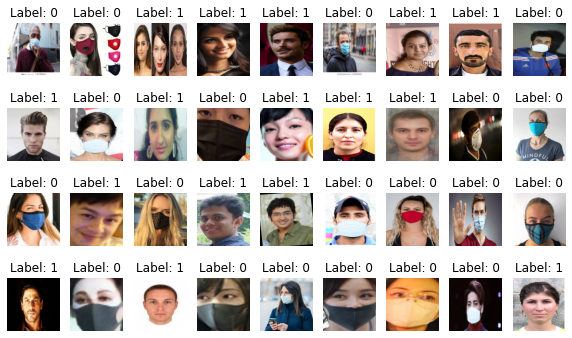

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10,6))
num_of_images = 36
for index in range(1, num_of_images + 1):
    plt.subplot(4, 9, index)
    plt.axis('off')
    plt.imshow(np.transpose(images[index].numpy(), (1,2,0)))
    plt.title("Label: {}".format(labels[index].item()))
print(images.shape)
del dataiter, images, labels

## Model
<div dir='rtl'style="text-align: right;font-family:verdana;">
در این بخش مدل شبکه عصبی متشکل از لایه های مخفی پیچیده و خطی آورده شده است. مدل نهایی در نظر گرفته شده از دو لایه پیچیده و دو لایه خطی تشکیل شده است. در لایه های پیچیده از فیلترهای 3 در 3 و به تعداد به ترتیب 10 و 6 عدد استفاده شده است. همچنین از max pooling در لایه های اول و دوم به ترتیب با اندازه پنجره 8 و 4 استفاده شده است. در لایه خطی اول از 60 نرون و در لایه خروجی به دلیل اینکه مساله دو کلاسه است از دو نرون استفاده شده است. برای توابع فعال ساز در لایه های میانی از رلو و در لایه خروجی از سافت مکس استفاده شده است.
</div>

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.bconv1 = nn.BatchNorm2d(10)
        
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=6, kernel_size=3)
        self.bconv2 = nn.BatchNorm2d(6)
        
        self.fc1 = nn.Linear(in_features=6*6*6, out_features=60)
        self.bc1 = nn.BatchNorm1d(60)
        
        self.out = nn.Linear(in_features=60, out_features=2)

    def forward(self, x):
        # (1) input layer
        h = x

        # (2) hidden conv layer
        h = self.conv1(h)
        h = self.bconv1(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=8, stride=8)
        
        # (3) hidden conv layer
        h = self.conv2(h)
        h = self.bconv2(h)
        h = F.relu(h)
        h = F.max_pool2d(h, kernel_size=4, stride=4)
        
        # (4) hidden linear layer
        h = h.reshape(-1, 6 * 6* 6)
        h = self.fc1(h)
        h = self.bc1(h)
        h = F.relu(h)
        #h = F.dropout(h, p=0.2, training=self.training)
        
        # (5) output layer
        h = self.out(h)
        out = F.softmax(h, dim=1)

        return out
    
#model = Model()
#model.cuda() # CUDA!
model_cpu = Model()
learning_rate = 0.001
#optimizer = optim.SGD(model_cpu.parameters(), lr=learning_rate)
optimizer = optim.Adam(model_cpu.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(model_cpu.parameters(), lr=learning_rate)

## Train and Validation
<div dir='rtl'style="text-align: right;font-family:verdana;">
در این بخش مدل آموزش داده شده و ارزیابی نیز انجام شده است
</div>

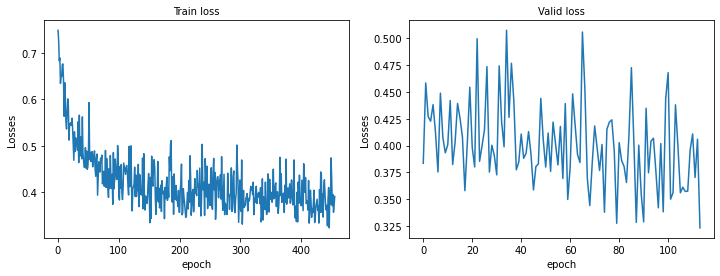


For Train:
Accuracy: 0.925 Precision: 0.925 Recall: 0.9347826086956521 F1_Score: 0.9245757385292268

For Valid:
Accuracy: 0.9 Precision: 0.925823129920051 Recall: 0.925823129920051 F1_Score: 0.925823129920051


In [11]:
model_cpu.train()

Acc_train = []
Acc_valid = []
losses_train = []
losses_valid = []
Yp_T = np.zeros(len_train_ds)
Yp_V = np.zeros(len_test_ds)
Epochs = 3
for epoch in range(Epochs):
    train = True        
    for batch_idx, (data, target) in enumerate(train_loader):
       
        # Get Samples
        data, target = Variable(data), Variable(target)
               
        # Init
        optimizer.zero_grad()

        # Predict
        Yp = model_cpu(data)

        # Calculate loss
        loss_t = F.cross_entropy(Yp, target)
        
        # Backpropagation
        loss_t.backward()
        losses_train.append(float(loss_t))
        optimizer.step()
        
        # Metric
        Yp = np.argmax(Yp.detach().numpy(), 1)
        target = target.numpy()
        acc_t = target == Yp
        acc_t = np.sum(acc_t) / acc_t.shape[0]
        Acc_train.append(float(acc_t))
        print('\r Epoch:{}\tbatch:{}\tTrain Loss: {:.6f}\tTrain Accuracy: {:.6f}'
              .format(epoch, batch_idx, loss_t, acc_t), end='')        
        if batch_idx == len(train_loader)-2:
            Train_acc = acc_t
            [Train_precision, Train_recall, Train_fscore, n] = precision_recall_fscore_support(
            target, Yp, average='macro')
        
        del data, target, Yp, loss_t
    
    train = False
    Yp_V = []
    Y_V = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = Variable(data), Variable(target)

        Yp = model_cpu(data)
        loss_v = F.cross_entropy(Yp, target)
        losses_valid.append(float(loss_v))

        Yp = np.argmax(Yp.detach().numpy(), 1)
        target = target.numpy()
        acc_v = target == Yp
        acc_v = np.sum(acc_v) / acc_v.shape[0]
        Acc_valid.append(float(acc_v))
        Yp_V.extend(Yp)        
        Y_V.extend(target)        
        del data, loss_v
        
    [Valid_precision, Valid_recall, Valid_fscore, n] = precision_recall_fscore_support(
            Y_V, Yp_V, average='macro')        
    
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(losses_train)
plt.title('Train loss' , fontsize=10)
plt.xlabel('epoch' , fontsize=10)
plt.ylabel('Losses', fontsize=10)

plt.subplot(1, 2, 2)
plt.plot(losses_valid)
plt.title('Valid loss' , fontsize=10)
plt.xlabel('epoch' , fontsize=10)
plt.ylabel('Losses', fontsize=10)
plt.show()

print('\nFor Train:')
print('Accuracy:', Train_acc, 'Precision:', Train_precision,
      'Recall:', Train_recall, 'F1_Score:', Train_fscore)
print('\nFor Valid:')
print('Accuracy:', Acc_valid[len(Acc_valid)-2], 'Precision:', Valid_precision,
      'Recall:', Valid_recall, 'F1_Score:', Valid_fscore)


<div dir="rtl">
    
# تنظیم هایپر پارامترها
    
    - تعدا لایه ها
    
    برا ی تعداد لایه ها چند مورد آزمایش شد. نخست تعدا 3 لایه پیچیده در نظر گرفته شد و سه لایه خطی.و نتایج گرفته شد پس از آن برای آنکه امکان انجام مساله با مدل ساده تر به لحاظ افزایش سرعت اجرا بررسی شود مدل ساده تر شد و دو لایه پیچیده به همراه دو لایه خطی در نظر گرفته شد. مشاهده شد که دقت نتایج تغییر نکرد. پس از آن یکی از لایه های پیچیده کم شد که این کار باعث کم شدن دقت شد بنابراین تعداد دو لایه پیچیده و دو لایه خطی در نهایت به عنوان مدل نهایی انتخاب شد
    
    - ابعاد فیلترها
    
    برای فیلترها نخست ابعاد 5 در 5 در نظر گرفته شد و نتایج گرفته شد. پس از آن ابعاد 7 در 7 انتخاب شد که به دلیل افزایش ابعاد فیلترها سرعت پردازش کاهش یافت. در آزمایش سوم ابعاد فیلترها 3 در 3  در نظر گرفته شد که مشاهده شد علاوه بر نتایج مشابه نسبت به ابعاد 5 در 5 باعث کم شدن تعداد وزن ها و در نتیچه افزایش سرعت پردازش شد. به همین دلیل در نهایت ابعاد فیلتر 3 در 3 در نظر گرفته شد
    
    - تعدا فیلترها (کانالها)
    
    نخست برای لایه اول و دوم تعداد 4 فیلتر در نظر گرفته شد. نتایج به دست آمده دارای دقت بالایی نبود به دلیل آن که بر اثر تعداد کم فیلتر ها شبکه کانولوشن قادر به کشف همه ویژگی های مورد نیاز نبود. پس از آن تعداد فیلتر های لایه اول و دوم به تدریج افزایش یافت به نحوی که برای لایه اول 10 فیلتر و برای لایه دوم 6 فیلتر در نظر گرفته شد. نتایج به دست آمده دارای دقت قابل قبولی بود. پس از آن تعداد فیلتر ها باز هم افزایش یافت. این مساله باعث سنگین شدن شبکه و کاهش سرعت اجرا و در بعضی از اجراها موجب اورفیت شد. بنابراین تعداد بهینه فیلترها برای لایه اول و دوم به ترتیب 10 و 6 در نظر گرفته شد
    
    - تعداد نرون های لایه خطی
    
    برای نرون های لایه خطی نخست تعداد 120 نرون در نظر گرفته شد. به دلیل آنکه در مدلهای خطی حالت فولی کانکت وجود دارد تعداد بالای نرونها در این لایه باعث افزایش تعداد پارامترهای وزن و سنگین شدن شبکه می شود به همین دلیل در اجراهای بعدی به تدریج تعداد نرون ها در این لایه کاهش یافت و  در نهایت مقدار 60 نرون به عنوان عدد بهینه در مدل در نظر گرفته شد.
    
    - لایه های Max Pooling
    
     برای آنکه بتوان از ویژگی های مثبت مکس پولینگ استفاده کرد. در این برنامه از این لایه ها در شبکه استفاده شد. از آنجا که ابعاد پنجره های مکس پولینک معمولا اعداد 2 یا 4 یا 8 در نظر گرفته می شود در نهایت در این شبکه برای لایه اول مکس پولینگ 8 و برای لایه دوم مکس پولینگ 4 در نظر گرفته شد. چون در این مساله شبکه باید دنبال یک آبجکت به نام ماسک بگردد و ابعاد تصاویر نسبتا بزرگ هستند امکان استفاده از مکس پولینگ 8 فراهم شد و به سرعت اجرا و پردازش برنامه کمک فراوانی کرد
    
    - توابع فعال ساز
    
    در این مساله به دلیل ویژگی های مثبتی که تابع رلو دارد از آن برای لایه های میانی استفاده شد. همچنین در لایه خروجی از فعال ساز سافت مکس استفاده شد تا در این مساله که یک ساله دو کلاسه است بتوان از ویژگیهای مثبت آن استفاده کرد.
    
    - نرخ یاگیری
    
    تنظیم نرخ یادگیری بر اساس انتخاب توابع بهینه ساز انجام شد که در بخش بعدی به توضیح آن پرداخته شده است.
    
        
    - تعداد ایپاک
    
    به دلیل آن که در این تکلیف ار مینی بچ استفاده شده و در این روش بروزرسانی در هر بچ انجام می شود انتظار است با تعداد کم ایپاک مساله به پاسخ قابل قبول برسد. در این تکلیف مشاهده شد با انجام 3 ایپاک پاسخ های نهایی به دست می آید و پس از آن تغییری در مقادیر برپزرسانی ها و دقت به دست آمده حاصل نمی شود. بنابراین برای این مساله تعداد ایپاک برابر با 3 در نظر گرفته شده است.
    
    
# توابع فعال ساز
    
    - در این تکلیف از سه تا از توابع فعال ساز زیر استفاده شد. برای مقایسه عملکرد برای همه آنها تعداد ایپاک 3 در نظر گرفته شده است
    
    نخست از تابع SGD استفاده شد که نتایج آن در شکل زیر آورده شده است
    
<img src="figures/SGD.png" style="width:800px;height:400px;">

    همان گونه که از شکل مشخص است با گذشت سه ایپاک مقادیر هزینه به مقدار کمینه خود نرسیده همچنین دقت آموزش و ارزیابی برای آن مقادیر کمی به دست آمده است. اما با افزایش تعداد ایپاک انتظار می رود این روش به پاسخ بهینه برسد.
    
    پس از آن از تابه بهینه ساز RMSProp استفاده شد که نتایج آن در زیر مشاهده می شود:
    
<img src="figures/RMSProp.png" style="width:800px;height:400px;">
    
    همان گونه که از شکل مشخص است، تابع بهینه ساز RMSProp در ۳ ایپاک به نتایج خوبی می رسد همان گونه که از اعداد به دست آمده مشخص است دقت در آموزش 97 درصد و در ارزیابی مقدار 95 درصد به دست آمده است. متریک های دیگر نیز مانند ریکال و صحت و امتیاز f نیز در برنامه محاسبه شده که در زیر شکل خروجی آنها نشان داده شده است. 
    
    پس از آن از تابه بهینه ساز Adam استفاده شد که نتایج آن در زیر مشاهده می شود:
    
<img src="figures/Adam.png" style="width:800px;height:400px;">
    
    همان گونه که از شکل مشخص است، تابع بهینه ساز Adam در ۳ ایپاک به نتایج خوبی می رسد همان گونه که از اعداد به دست آمده مشخص است دقت در آموزش 97 درصد و در ارزیابی مقدار 97 درصد به دست آمده است. متریک های دیگر نیز در زیر شکل  نشان داده شده است. با مقایسه نتایج مشخص شد تابع Adam نسبت به دو تابع دیگر در تعداد ایپاک کمتر به نتایج نسبتابهتری برای دقت می رسد. البته در برخی از اجراها نتایج RMSProp و Adam بسیار به یکدیگر نزدیک بودند و نتایج آنها قابل قبول بود حتی در برخی از اجراها دقت RMSProp از Adam بیشتر به دست آمد. بنابراین هر کدام از این دو تابع را می توان به عنوان انتخاب نهایی در نظر گرفت 
    
    - انتخاب نرخ یادگیری
    
    برای نرخ یادگیری در این تکلیف مقادیر مختلفی در نظر گرفته شد. به عنوان مثال در شکل زیر نتایج به دست آمده با استفاده از تابع بهینه ساز Adam و استفاده از نرخ یادگیری 0.01 نشان داده شده است
    
<img src="figures/Adam01.png" style="width:800px;height:400px;">
    
    همان گونه که مشخص است مقادیر دقت نسبت به حالت قبلب کاهش یافته است. همچنین در ادامه مقادیر دیگر نیز در نظر گرفته شد که مقادیر کمتر از 0.001 موجب کاهش سرعت یادگیری و مقادیر بیشتر از آن باعث کاهش دقت شبکه شد. بنابراین نرخ یادگیری برابر با 0.001 به عنوان مقدار بهینه در نظر گرفته شد.

## Face detection
<div dir='rtl'style="text-align: right;font-family:verdana;">
در این بخش به مساله تشخیص صورت پرداخته شده است. به این منظور از تابع آماده extract_face که در اینترنت موجود است استفاده شده است. در زیر این تابع آورده شده است. برای استفاده از این تابع باید مسیر تصویر به عنوان ورودی به تابع داده شود و پس از آن تابع صورت را از روی تصویر تشخیص داده و آن را به صورت یک تصویر جداگانه ذخیره می کند. خروچی تابع تصویر به دست آمده به همراه مسیر آن است که پس از آن باید با استفاده از دستور imread خوانده شود.
</div>

In [6]:
import sys
import os
import cv2
from extract_face.data import *

""" Load cascade xml file and save to FACE_CASCADE
"""
FACE_CASCADE = cv2.CascadeClassifier(haarcascade_frontalface_default)

def extract_face(image_path,
                scale_factor=1.1,
                min_neighbors=5,
                output_directory=None,
                output_prefix=None):
    """ Extract the human face from image and return number of detected face
    image_path -- The path of the image.
    scale_factor -- Specifying how much the image size is reduced at each image scale (default 1.1).
    min_neighbors -- Specifying how many neighbors each candidate rectangle should have to retain it (default 5).
    output_directory -- Directory where to save output (default None - same as input image)
    output_prefix -- Prefix of output (default None - the name of input image)
    """


    if not os.path.exists(image_path):
        """ If given image file does not exist
        """
        raise FileNotFoundError("Happens when given file not exist")

    try:    
        if float(scale_factor) < 1.1:
            """ If given scale factor less than default i.e 1.1
            """
            raise ValueError("Happens when scale factor less than default i.e 1.1")
    except:
        raise ValueError("Happens when scale factor less than default i.e 1.1")

    if not output_prefix:
        output_prefix = os.path.splitext(os.path.split(image_path)[1])[0]

    if not output_directory:
        output_directory = os.path.split(image_path)[0]
    else:
        if not os.path.exists(output_directory):
            try:
                os.mkdir(output_directory)
            except PermissionError as e:
                raise PermissionError("Exception while creating directory")

    try:    
        img = cv2.imread(image_path)
    except:
        raise TypeError("Happens when given image not correct")

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    try:
        faces = FACE_CASCADE.detectMultiScale(gray_img, scale_factor, min_neighbors)
    except Exception as e:
        raise ValueError(str(e))

    width, height = img.shape[:2]
    count = 1
    for (x, y, w, h) in faces:
        y1 = int(y)
        y2 = int(y + h)
        x1 = int(x)
        x2 = int(x + w)

        if y1 < 0: y1 = 0

        if y2 > width: y2 = width

        if x1 < 0: x1 = 0

        if x2 > height: x2 = height

        crop_img = img[y1:y2, x1:x2]

        file_path = os.path.join(
                output_directory, output_prefix + '_' + str(count) + '_' + '.jpg')
        count = count + 1
        try:        
            cv2.imwrite(file_path, crop_img)
        except PermissionError as e:
            raise PermissionError("Exception while creating new image")


    return file_path

<div dir="rtl">
    
    در این بخش نخست دو تصویر یکی بدون ماسک و دیگری با ماسک از خود تهیه شد که در زیر این تصاویر خوانده و رسم شدند. پس از اجرای این قسمت از برنامه تصاویر قابل مشاهده هستند.
    


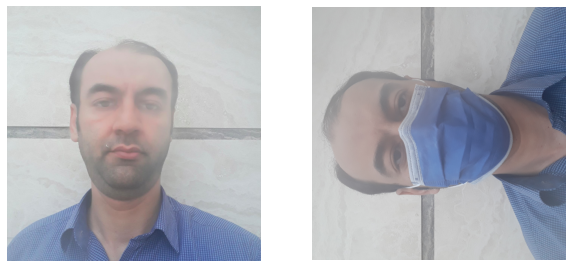

In [7]:
image_without = plt.imread('ehsan_data/Ehsan_without.jpeg')
image_with = plt.imread('ehsan_data/Ehsan_with.jpeg')
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image_without)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image_with)

<div dir="rtl">
    
    پس از ذخیره تصاویر در این بخش از برنامه تابع تشخیص صورت اعمال می شود. با اجرای بخش زیر از برنامه قسمت صورت از تصویر اصلی جدا شده و به عنوان یک تصویر جداگانه رسم خواهد شد.


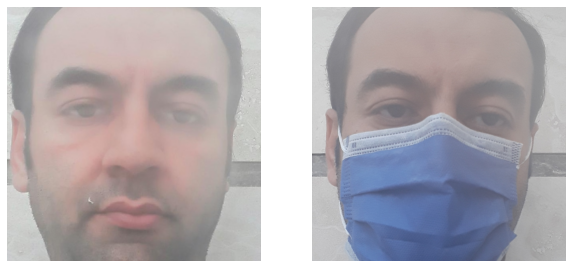

In [8]:
face_without = plt.imread(extract_face(image_path = 'ehsan_data/Ehsan_without.jpeg'))
face_with = plt.imread(extract_face(image_path = 'ehsan_data/Ehsan_with.jpeg'))
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(face_without)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(face_with)

## Test with my personal images

<div dir="rtl">
    
    در این بخش مدل آموزش داده شده بر روی خروچی تابع تشخیص چهره اعمال شد و با اجرای خطوط زیر از برنامه دقت به دست آمده و همچنین هر یک از تصاویر با برچسب اصلی و برچسب پیش بینی شده توسط مدل جهت مقایسه عملکرد مدل ترسیم شده است. در زیر به عنوان نمونه نتایج یکی از اجراهای این بخش از برنامه نشان داده شده است.
    
<img src="figures/EhsanAcc.png" style="width:800px;height:400px;">
 
    همان گونه که مشاهده می شود مدل توانسته با دقت کامل چهره بدون ماسک را از چهره ماسک دار تشخیص دهد.


Dataset ImageFolder
    Number of datapoints: 2
    Root location: ehsan_data_face
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Number of test samples: 2
Number of test batchs: 1
Accuracy is:  1.0


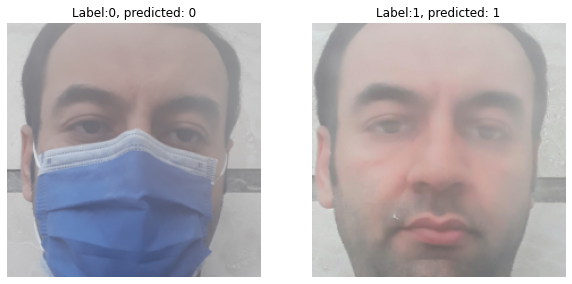

In [9]:
my_data_dir = 'ehsan_data_face'
my_dataset = ImageFolder(my_data_dir,transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                                             transforms.ToTensor()]))
my_test_loader = DataLoader(my_dataset,
                          batch_size=2,
                          num_workers=0)
print(my_dataset)
print("Number of test samples:", len(my_dataset))
print("Number of test batchs:", len(my_test_loader))

dataiter = iter(my_test_loader)
images, labels = dataiter.next()
Yp = model_cpu(images)
Yp = np.argmax(Yp.detach().numpy(), 1)
labels = labels.numpy()
acc = labels == Yp
acc = np.sum(acc) / 2

plt.figure(figsize=(10,6))
num_of_images = 2
for index in range(2):
    plt.subplot(1, 2, index+1)
    plt.axis('off')
    plt.imshow(np.transpose(images[index].numpy(), (1,2,0)))
    plt.title("Label:{}, predicted: {}".format(labels[index].item(), Yp[index]))
print('Accuracy is: ', acc)

<div dir="rtl">
    
    در این بخش 20 تصویر شامل 10 تصویر بدون ماسک و 10 تصویر با ماسک از اینترنت استخراج شد و هر دسته در مسیری ذخیره شدند.  پس از اجرای این قسمت از برنامه تصاویر قابل مشاهده هستند.
    

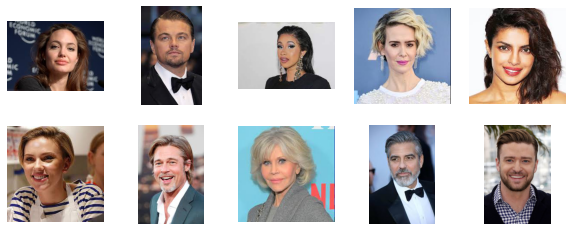

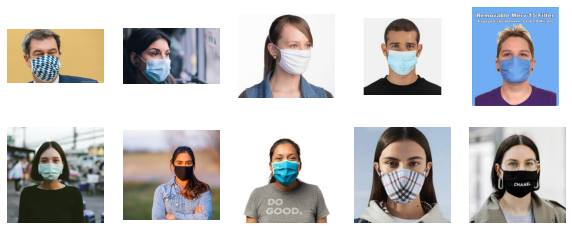

In [10]:
plt.figure(figsize=(10,4))
main_path = 'internet_data/without_mask/image'
for index in range(10):
    image = plt.imread(main_path + str(index+1) + '.jpeg')
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(image)
    
plt.figure(figsize=(10,4))
main_path = 'internet_data/with_mask/image'
for index in range(10):
    image = plt.imread(main_path + str(index+1) + '.jpeg')
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(image)

<div dir="rtl">
    
    پس از ذخیره تصاویر در این بخش از برنامه تابع تشخیص صورت بر روی هر یک از تصاویر اعمال شد. با اجرای بخش زیر از برنامه قسمت صورت از تصویر اصلی جدا شده و به عنوان یک تصویر جداگانه رسم خواهد شد.


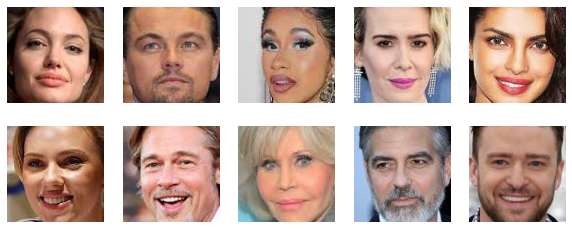

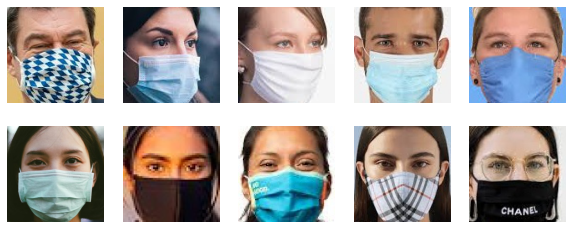

In [11]:
plt.figure(figsize=(10,4))
main_path = 'internet_data/without_mask/image'
for index in range(10):
    face = plt.imread(extract_face(image_path = main_path + str(index+1) + '.jpeg'))
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(face)
    
plt.figure(figsize=(10,4))
main_path = 'internet_data/with_mask/image'
for index in range(10):
    face = plt.imread(extract_face(image_path = main_path + str(index+1) + '.jpeg'))
    plt.subplot(2, 5, index+1)
    plt.axis('off')
    plt.imshow(face)

## Test with internet images

<div dir="rtl">
    
    در این بخش مدل آموزش داده شده بر روی خروجی تابع تشخیص چهره اعمال شد و با اجرای خطوط زیر از برنامه دقت به دست آمده و همچنین هر یک از تصاویر با برچسب اصلی و برچسب پیش بینی شده توسط مدل جهت مقایسه عملکرد مدل ترسیم شده است. در زیر به عنوان نمونه نتایج یکی از اجراهای این بخش از برنامه نشان داده شده است.
    

<img src="figures/InternetHighAcc.png" style="width:800px;height:600px;">
 
    همان گونه که مشاهده می شود مدل توانسته با دقت کامل چهره بدون ماسک را از چهره ماسک دار تشخیص دهد.


Dataset ImageFolder
    Number of datapoints: 20
    Root location: internet_data_face
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Number of test samples: 20
Number of test batchs: 1
Accuracy is:  1.0


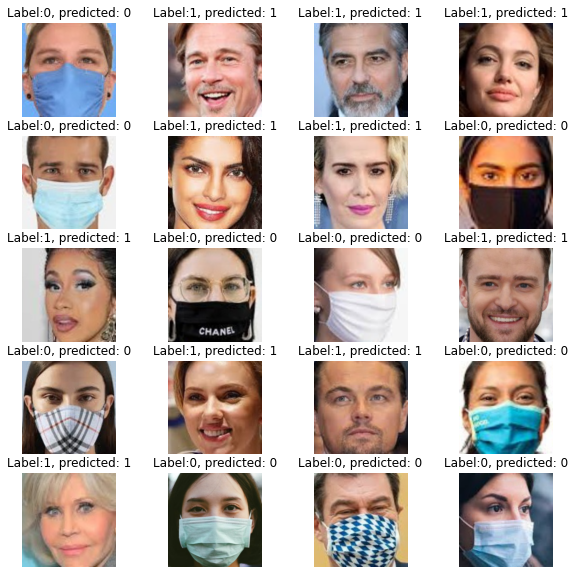

In [12]:
internet_data_dir = 'internet_data_face'
internet_dataset = ImageFolder(internet_data_dir,transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                                             transforms.ToTensor()]))
internet_test_loader = DataLoader(internet_dataset,
                          batch_size=20,
                          shuffle=True,                
                          num_workers=0)
print(internet_dataset)
print("Number of test samples:", len(internet_dataset))
print("Number of test batchs:", len(internet_test_loader))

dataiter = iter(internet_test_loader)
images, labels = dataiter.next()

Yp = model_cpu(images)
Yp = np.argmax(Yp.detach().numpy(), 1)
labels = labels.numpy()
acc = labels == Yp
acc = np.sum(acc) / acc.shape[0]

plt.figure(figsize=(10,10))
num_of_images = 20
for index in range(20):
    plt.subplot(5, 4, index+1)
    plt.axis('off')
    plt.imshow(np.transpose(images[index].numpy(), (1,2,0)))
    plt.title("Label:{}, predicted: {}".format(labels[index].item(), Yp[index]))
print('Accuracy is: ', acc)

## Transfer learning

<div dir='rtl'style="text-align: right;font-family:verdana;">
    
    در این بخش یادگیری انتقالی انجام شده است. برای این کار از دیتاست Resnet18 استفاده شده است.در برنامه نوشته شده در بلوک زیر یادگیری انتقالی با استفاده از این دیتاست انجام شده است. نخست دیتاست دانلود شده و با نام model نام گذاری شده است. این کار با استفاده از دستورهای دو خط اول بلوک زیر انجام شده است.
    
    پس از آن لایه های پیچیده مدل فریز شده است. این کار با استفاده از دستورهای نوشته شده در خطوط سوم و چهارم انجام شده است. در این دستورها در واقع عمل گرادیان گیری به منظور بروزرسانی متوقف یا فریز شده است. در ادامه برنامه لایه خطی یا فولی کانکتد مدل تغییر کرده است به نحوی که تعداد نرون در آخرین لایه برابر با 2 قرار داده شده است.   

</div>

In [15]:
model = models.resnet18(pretrained=True)
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)


## Train
<div dir='rtl'style="text-align: right;font-family:verdana;">
    
    در این بخش آموزش مدل انجام شده است. همچنین همانند بخش قبلی ارزیابی مدل در حین آموزش نیز انجام شده است. نتایج به دست آمده نشان داد مدل به دست آمده با استفاده از یادگیری انتقالی از دقت بسیار بالایی در آموزش و ارزیابی برخوردار است. در زیر نمونه ای از نتایج یکی از اجراهای برنامه آورده شده است:
    
<img src="figures/Transfer.png" style="width:800px;height:400px;">
    
    همان گونه که مشاهده می شود مدل از دقت بسیار بالایی در آموزش و ارزیابی بر خوردار است.


</div>

 Epoch:0	batch:96	Train Loss: 0.123548	Train Accuracy: 0.950000

/home/ehsan/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 Epoch:0	batch:151	Train Loss: 0.411246	Train Accuracy: 0.750000

/home/ehsan/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 Epoch:1	batch:83	Train Loss: 0.101019	Train Accuracy: 0.975000

/home/ehsan/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 Epoch:1	batch:151	Train Loss: 0.169868	Train Accuracy: 1.000000

/home/ehsan/anaconda3/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


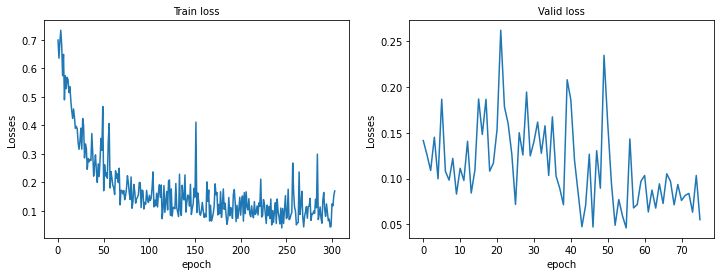


For Train:
Accuracy: 0.925 Precision: 0.925 Recall: 0.9347826086956521 F1_Score: 0.9245757385292268

For Valid:
Accuracy: 0.95 Precision: 0.9734564521563343 Recall: 0.973556173385568 F1_Score: 0.9734994734994735


In [16]:
model.train()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Acc_train = []
Acc_valid = []
losses_train = []
losses_valid = []
Yp_T = np.zeros(len_train_ds)
Yp_V = np.zeros(len_test_ds)
Epochs = 2
for epoch in range(Epochs):
    train = True        
    for batch_idx, (data, target) in enumerate(train_loader):
       
        # Get Samples
        data, target = Variable(data), Variable(target)
               
        # Init
        optimizer.zero_grad()

        # Predict
        Yp = model(data)

        # Calculate loss
        loss_t = F.cross_entropy(Yp, target)
        
        # Backpropagation
        loss_t.backward()
        losses_train.append(float(loss_t))
        optimizer.step()
        
        # Metric
        Yp = np.argmax(Yp.detach().numpy(), 1)
        target = target.numpy()
        acc_t = target == Yp
        acc_t = np.sum(acc_t) / acc_t.shape[0]
        Acc_train.append(float(acc_t))
        print('\r Epoch:{}\tbatch:{}\tTrain Loss: {:.6f}\tTrain Accuracy: {:.6f}'
              .format(epoch, batch_idx, loss_t, acc_t), end='')        
        if batch_idx == len(train_loader)-2:
            Train_acc = acc_t
            [Train_precision, Train_recall, Train_fscore, n] = precision_recall_fscore_support(
            target, Yp, average='macro')
        
        del data, target, Yp, loss_t
    
    train = False
    Yp_V = []
    Y_V = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = Variable(data), Variable(target)

        Yp = model(data)
        loss_v = F.cross_entropy(Yp, target)
        losses_valid.append(float(loss_v))

        Yp = np.argmax(Yp.detach().numpy(), 1)
        target = target.numpy()
        acc_v = target == Yp
        acc_v = np.sum(acc_v) / acc_v.shape[0]
        Acc_valid.append(float(acc_v))
        Yp_V.extend(Yp)        
        Y_V.extend(target)        
        del data, loss_v
        
    [Valid_precision, Valid_recall, Valid_fscore, n] = precision_recall_fscore_support(
            Y_V, Yp_V, average='macro')        
    
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(losses_train)
plt.title('Train loss' , fontsize=10)
plt.xlabel('epoch' , fontsize=10)
plt.ylabel('Losses', fontsize=10)

plt.subplot(1, 2, 2)
plt.plot(losses_valid)
plt.title('Valid loss' , fontsize=10)
plt.xlabel('epoch' , fontsize=10)
plt.ylabel('Losses', fontsize=10)
plt.show()

print('\nFor Train:')
print('Accuracy:', Train_acc, 'Precision:', Train_precision,
      'Recall:', Train_recall, 'F1_Score:', Train_fscore)
print('\nFor Valid:')
print('Accuracy:', Acc_valid[len(Acc_valid)-2], 'Precision:', Valid_precision,
      'Recall:', Valid_recall, 'F1_Score:', Valid_fscore)


## Test with my personal images

<div dir="rtl">
    
    در این بخش مدل آموزش داده شده با استفاده از یادگیری انتقالی بر روی خروجی تابع تشخیص چهره اعمال شد و با اجرای خطوط زیر از برنامه دقت به دست آمده و همچنین هر یک از تصاویر با برچسب اصلی و برچسب پیش بینی شده توسط مدل جهت مقایسه عملکرد مدل ترسیم شده است. در زیر به عنوان نمونه نتایج یکی از اجراهای این بخش از برنامه نشان داده شده است.
    
<img src="figures/TransferEhsan.png" style="width:800px;height:400px;">
 
    همان گونه که مشاهده می شود مدل توانسته با دقت کامل چهره بدون ماسک را از چهره ماسک دار تشخیص دهد.


Dataset ImageFolder
    Number of datapoints: 2
    Root location: ehsan_data_face
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Number of test samples: 2
Number of test batchs: 1
Accuracy is:  1.0


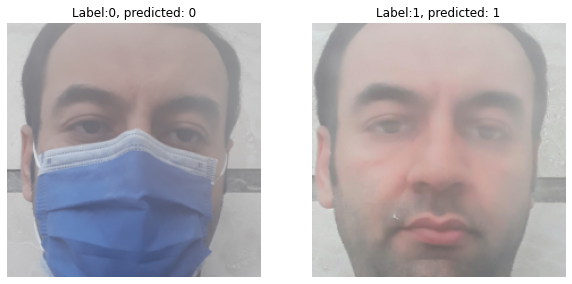

In [17]:
my_data_dir = 'ehsan_data_face'
my_dataset = ImageFolder(my_data_dir,transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                                             transforms.ToTensor()]))
my_test_loader = DataLoader(my_dataset,
                          batch_size=2,
                          num_workers=0)
print(my_dataset)
print("Number of test samples:", len(my_dataset))
print("Number of test batchs:", len(my_test_loader))

dataiter = iter(my_test_loader)
images, labels = dataiter.next()
Yp = model(images)
Yp = np.argmax(Yp.detach().numpy(), 1)
labels = labels.numpy()
acc = labels == Yp
acc = np.sum(acc) / 2

plt.figure(figsize=(10,6))
num_of_images = 2
for index in range(2):
    plt.subplot(1, 2, index+1)
    plt.axis('off')
    plt.imshow(np.transpose(images[index].numpy(), (1,2,0)))
    plt.title("Label:{}, predicted: {}".format(labels[index].item(), Yp[index]))
print('Accuracy is: ', acc)

## Test with Internet images

<div dir="rtl">
    
    در این بخش به طور مشابه تست بر روی تصاویر برگرفته از اینترنت انجام شده است. در زیر نتایج یکی از اجراهای این بخش آورده شده است

<img src="figures/TransferInternet.png" style="width:800px;height:600px;">
 
    همان گونه که مشاهده می شود مدل توانسته با دقت خوب 95 درصد چهره بدون ماسک را از چهره ماسک دار تشخیص دهد.


Dataset ImageFolder
    Number of datapoints: 20
    Root location: internet_data_face
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Number of test samples: 20
Number of test batchs: 1
Accuracy is:  0.95


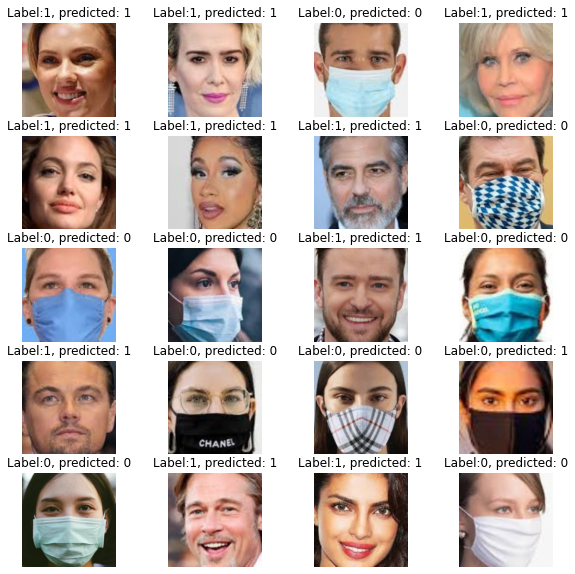

In [18]:
internet_data_dir = 'internet_data_face'
internet_dataset = ImageFolder(internet_data_dir,transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                                             transforms.ToTensor()]))
internet_test_loader = DataLoader(internet_dataset,
                          batch_size=20,
                          shuffle=True,                
                          num_workers=0)
print(internet_dataset)
print("Number of test samples:", len(internet_dataset))
print("Number of test batchs:", len(internet_test_loader))

dataiter = iter(internet_test_loader)
images, labels = dataiter.next()

Yp = model(images)
Yp = np.argmax(Yp.detach().numpy(), 1)
labels = labels.numpy()
acc = labels == Yp
acc = np.sum(acc) / acc.shape[0]

plt.figure(figsize=(10,10))
num_of_images = 20
for index in range(20):
    plt.subplot(5, 4, index+1)
    plt.axis('off')
    plt.imshow(np.transpose(images[index].numpy(), (1,2,0)))
    plt.title("Label:{}, predicted: {}".format(labels[index].item(), Yp[index]))
print('Accuracy is: ', acc)